# J-Quants API 株式市場分析デモ

本デモでは以下のユーザーを想定しています。

* Python / Pandas / Matplotlib / Seaborn についての知識を有していること
* J-Quants API アクセスキーを取得して Google Drive に保存していること
* Google Driveにアクセス可能であること
* (Optional) Google Cloud Storage を使用可能であること

In [1]:
# プロットで日本語を使用できるようにします
!pip install japanize-matplotlib

In [2]:
import os
from datetime import datetime

import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from dateutil import tz
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

In [3]:
# pandas の表示制限を調整します
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", 1000)
pd.set_option("display.width", 2000)

## データ保存用ディレクトリ設定

J-Quants APIから取得したデータを保存しておくためのディレクトリを設定します。

J-Quants APIから毎回全データを取得するのではデータ取得のために時間がかかってしまうため、取得したデータを保存しておいて必要な最新データのみを J-Quants API から取得します。
加えて、分析に必要な中間ファイルや結果ファイルの保存にも使用します。

データ量が多くなければ Google Drive で十分ですが、データ量が多くなってきた場合は Cloud Storage を使用するとよいでしょう。

### (Optional) Cloud Storage のマウント

取得したデータは、Google Drive に保存しておくことも可能ですが、データへのアクセスやデータ量が増加していくことを考慮すると、Cloud Storage に保存するのも一つの方法です。Colab と Cloud Storage は親和性が高く、以下のように gcsfuse というツールを使用することで Google Cloud Storage をマウントしてファイルシステムとして使用することが可能です。

Cloud Storage については [Cloud Storage](https://cloud.google.com/storage) をご参照ください。
gcsfuse については [GoogleCloudPlatform/gcsfuse](https://github.com/GoogleCloudPlatform/gcsfuse/) をご参照ください。

※デフォルトではコメントアウトしているため、使用するためにはコメントを外してください。
※使用される際はバケット名をご自身のバケット名に変更してください。

In [4]:
# Cloud Storage をマウントするパスを設定します
MOUNT_PATH = "/content/gcs/colab"
# マウントする Cloud Storage のバケット名を設定します
BUCKET_NAME = "colab-demo-alpaca-ai"

In [5]:
# # Google Cloud Storage を使用するためにユーザー認証を実施します。
# from google.colab import auth
# auth.authenticate_user()

In [6]:
# %%bash
# # install gcsfuse to mount Google Cloud Storage
# # ref. https://github.com/GoogleCloudPlatform/gcsfuse/blob/master/docs/installing.md
# # export APT_KEY_DONT_WARN_ON_DANGEROUS_USAGE=1
# export GCSFUSE_REPO=gcsfuse-`lsb_release -c -s`
# echo "deb http://packages.cloud.google.com/apt $GCSFUSE_REPO main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
# curl -s https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
# apt-get -qq update
# apt-get -qq install gcsfuse

In [7]:
# # # mount Google Cloud Storage Bucket
# ! mkdir -p $MOUNT_PATH
# ! gcsfuse $BUCKET_NAME $MOUNT_PATH
# ! touch $MOUNT_PATH/mount_check

### データ保存用ディレクトリへのパスを設定

In [8]:
# check mounted Cloud Storage
if os.path.isfile(f"{MOUNT_PATH}/mount_check"):
  # use Cloud Storage
  STORAGE_DIR_PATH = f"{MOUNT_PATH}/marketdata"
else:
  # use google drive
  STORAGE_DIR_PATH = "/content/drive/MyDrive/drive_ws/marketdata"
os.makedirs(STORAGE_DIR_PATH, exist_ok=True)
STORAGE_DIR_PATH

'/content/drive/MyDrive/drive_ws/marketdata'

## J-Quants API のアクセスキー取得

J-Quants APIにアクセスするためには J-Quants API の Web サイトから取得できるアクセスキーが必要になります。
取得したアクセスキーを Google Drive に配置してから以下の作業をすすめます。

※ Google Drive 上のファイル経由でアクセスキーを取り扱っているのは、このような公開の場でデモする際にアクセスキーを画面上に露出させないためです。

In [9]:
ACCESS_KEY_FILE_PATH = "/content/drive/MyDrive/drive_ws/secret/jquantsapi-key.txt"

In [10]:
def get_access_key(access_key_file_path: str =ACCESS_KEY_FILE_PATH):
  with open(access_key_file_path, "r") as f:
    access_key = f.read()
  return access_key.rstrip().lstrip()

In [11]:
access_key = get_access_key()

## J-Quants API アクセスクライアント作成

J-Quants API はシンプルな Web API 実装となっています。そのまま個別に扱ってもよいのですが、データ分析用途で繰り返し同じ作業をするため、それらをまとめて管理しやすいように、ここではクライアントクラスを作成しています。

* ラッパー群　J-Quants API の各APIエンドポイントに対応しています。
  * get_listed_info
  * get_listed_sections
  * get_market_segments
  * get_prices_daily_quotes
  * get_fins_statements
  * get_fins_announcement
* ユーティリティー群　日付範囲を指定して一括でデータ取得して、取得したデータを結合して返すようなユーティリティーメソッドです。
  * get_list
  * get_price_all
  * get_statements_all

In [12]:
class JQuantsAPIDemo:
  """
  J-Quants API からデータを取得する
  ref. https://jpx.gitbook.io/j-quants-api/
  """
  JQUANTS_API_BASE = "https://api.jpx-jquants.com/v1"

  def __init__(self, access_key: str) -> None:
    """
    Args:
        access_key: J-Quants API アクセストークン
    """
    self.access_key = access_key

  def _base_headers(self) -> dict:
    """
    J-Quants API にアクセスする際にヘッダーにアクセストークンを設定
    """
    headers = {"Authorization": f"Bearer {self.access_key}"}
    return headers
  
  def _get(self, url: str, params: dict = None) -> requests.Response:
    """
    requests の get 用ラッパー

    リトライを設定
    ヘッダーにアクセストークンを設定
    タイムアウトを設定

    Args:
        url: アクセスするURL
        params: パラメーター

    Returns:
        requests.Response: レスポンス
    """
    retry_strategy = Retry(
        total=3,
        status_forcelist=[429, 500, 502, 503, 504],
        method_whitelist=["HEAD", "GET", "OPTIONS"]
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)
    s = requests.Session()
    s.mount("https://", adapter)
    s.mount("http://", adapter)

    headers = self._base_headers()
    ret = s.get(url, params=params, headers=headers, timeout=30)
    ret.raise_for_status()
    return ret

  def get_listed_info(self, code: str = "") -> pd.DataFrame:
    """
    銘柄一覧を取得

    Args:
        code: 銘柄コード (Optional)

    Returns:
        pd.DataFrame: 銘柄一覧
    """
    url = f"{self.JQUANTS_API_BASE}/listed/info"
    params = {"code": code}
    ret = self._get(url, params)
    d = ret.json()
    df = pd.DataFrame.from_dict(d["info"])
    cols = [
      "Code",
      "CompanyName",
      "CompanyNameEnglish",
      "CompanyNameFull",
      "SectorCode",
      "UpdateDate",
      "MarketCode"
    ]
    if len(df) == 0:
      return pd.DataFrame([], columns=cols)

    df.loc[:, "UpdateDate"] = pd.to_datetime(df["UpdateDate"], format="%Y%m%d")
    df.sort_values("Code", inplace=True)

    return df[cols]

  def get_listed_sections(self) -> pd.DataFrame:
    """
    セクター一覧を取得

    Args:
        N/A

    Returns:
        pd.DataFrame: セクター一覧
    """
    url = f"{self.JQUANTS_API_BASE}/listed/sections"
    params = {}
    ret = self._get(url, params)
    d = ret.json()
    df = pd.DataFrame.from_dict(d["sections"])
    cols = ["SectorId", "SectorName"]
    if len(df) == 0:
      return pd.DataFrame([], columns=cols)
    df.sort_values("SectorId", inplace=True)
    return df[cols]

  def get_market_segments(self) -> pd.DataFrame:
    """
    市場区分一覧を取得

    Args:
        N/A

    Returns:
        pd.DataFrame: 市場区分一覧
    """

    df = pd.DataFrame(
      [
        {"MarketCode": "", "Market": "東証非上場"},                           
        {"MarketCode": "1", "Market": "市場一部"},
        {"MarketCode": "2", "Market": "市場二部"},
        {"MarketCode": "3", "Market": "マザーズ"},
        {"MarketCode": "5", "Market": "その他"},
        {"MarketCode": "6", "Market": "JASDAQ スタンダード"},
        {"MarketCode": "7", "Market": "JASDAQ グロース"},
        {"MarketCode": "8", "Market": "TOKYO PRO Market"},
        {"MarketCode": "9", "Market": "上場廃止"},
        {"MarketCode": "A", "Market": "プライム"},
        {"MarketCode": "B", "Market": "スタンダード"},
        {"MarketCode": "C", "Market": "グロース"},
      ]
    )
    cols = ["MarketCode", "Market"]
    df.sort_values("MarketCode", inplace=True)
    return df[cols]

  def get_list(self) -> pd.DataFrame:
    """
    銘柄一覧を取得 (市場区分およびセクター結合済み)

    Args:
        N/A

    Returns:
        pd.DataFrame: 銘柄一覧
    """
    df_list = self.get_listed_info()
    df_sectors = self.get_listed_sections()
    df_segments = self.get_market_segments()

    df_list = pd.merge(df_list, df_sectors, how="left", left_on=["SectorCode"], right_on=["SectorId"])
    df_list = pd.merge(df_list, df_segments, how="left", on=["MarketCode"])
    df_list.sort_values("Code", inplace=True)
    return df_list

  def get_prices_daily_quotes(
      self,
      code: str = "",
      from_yyyymmdd: str = "",
      to_yyyymmdd: str = "",
      date_yyyymmdd: str = ""
  ) -> pd.DataFrame:
    """
    株価情報を取得

    Args:
        code: 銘柄コード
        from_yyyymmdd: 取得開始日
        to_yyyymmdd: 取得終了日
        date_yyyymmdd: 取得日

    Returns:
        pd.DataFrame: 株価情報
    """
    url = f"{self.JQUANTS_API_BASE}/prices/daily_quotes"
    params = {
        "code": code,
    }
    if date_yyyymmdd != "":
      params["date"] = date_yyyymmdd
    else:
      if from_yyyymmdd != "":
        params["from"] = from_yyyymmdd 
      if to_yyyymmdd != "":
        params["to"] = to_yyyymmdd
    ret = self._get(url, params)
    d = ret.json()
    df = pd.DataFrame.from_dict(d["daily_quotes"])
    cols = [
      "Code",
      "Date",
      "Open",
      "High",
      "Low",
      "Close",
      "Volume",
      "TurnoverValue",
    ]
    if len(df) == 0:
      return pd.DataFrame([], columns=cols)
    df.loc[:, "Date"] = pd.to_datetime(df["Date"], format="%Y%m%d")
    df.sort_values(["Code", "Date"], inplace=True)
    return df[cols]
  
  def get_price_range(
    self,
    start_dt: datetime = datetime(2017, 1, 1, tzinfo=tz.gettz("Asia/Tokyo")),
    end_dt: datetime = datetime.now(tz.gettz("Asia/Tokyo"))
  ) -> pd.DataFrame:
    """
    全銘柄の株価情報を日付範囲指定して取得

    Args:
        start_dt: 取得開始日
        end_dt: 取得終了日

    Returns:
        pd.DataFrame: 株価情報
    """
    buff = []
    dates = pd.date_range(start_dt, end_dt, freq="D")
    counter = 1
    for s in dates:
      df = self.get_prices_daily_quotes(date_yyyymmdd=s.strftime("%Y%m%d"))
      buff.append(df)
      # progress log
      if (counter % 100) == 0:
        print(f"{counter} / {len(dates)}")
      counter += 1
    return pd.concat(buff)

  def get_fins_statements(
      self,
      code: str = "",
      date_yyyy_mm_dd: str = ""
  ) -> pd.DataFrame:
    """
    財務情報取得

    Args:
        code: 銘柄コード
        date_yyyy_mm_dd: 日付(YYYY-MM-DD)

    Returns:
        pd.DataFrame: 財務情報
    """
    url = f"{self.JQUANTS_API_BASE}/fins/statements"
    params = {
        "code": code,
        "date": date_yyyy_mm_dd,
    }
    ret = self._get(url, params)
    d = ret.json()
    df = pd.DataFrame.from_dict(d["statements"])
    cols = [
      "DisclosureNumber",
      "LocalCode",
      "DisclosedDate",
      "DisclosedTime",
      "DisclosedUnixTime",
      "TypeOfDocument",
      "CurrentPeriodEndDate",
      "TypeOfCurrentPeriod",
      "CurrentFiscalYearStartDate",
      "CurrentFiscalYearEndDate",
      "NetSales",
      "OperatingIncome",
      "OrdinaryIncome",
      "NetIncome",
      "NetIncomePerShare",
      "TotalAssets",
      "NetAssets",
      "CapitalAdequacyRatio",
      "NetAssetsPerShare",
      "ResultDividendPerShare1stQuarter",
      "ResultDividendPerShare2ndQuarter",
      "ResultDividendPerShare3rdQuarter",
      "ResultDividendPerShareFiscalYearEnd",
      "ResultDividendPerShareAnnual",
      "ForecastDividendPerShare1stQuarter",
      "ForecastDividendPerShare2ndQuarter",
      "ForecastDividendPerShare3rdQuarter",
      "ForecastDividendPerShareFiscalYearEnd",
      "ForecastDividendPerShareAnnual",
      "ForecastNetSales",
      "ForecastOperatingIncome",
      "ForecastOrdinaryIncome",
      "ForecastNetIncome",
      "ForecastNetIncomePerShare",
      "ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements",
      "ChangesBasedOnRevisionsOfAccountingStandard",
      "ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard",
      "ChangesInAccountingEstimates",
      "RetrospectiveRestatement",
      "NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock",
      "NumberOfTreasuryStockAtTheEndOfFiscalYear",
      "AverageNumberOfShares",
    ]
    if len(df) == 0:
      return pd.DataFrame([], columns=cols)
    df.loc[:, "DisclosedDate"] = pd.to_datetime(df["DisclosedDate"], format="%Y-%m-%d")
    df.loc[:, "CurrentPeriodEndDate"] = pd.to_datetime(df["CurrentPeriodEndDate"], format="%Y-%m-%d")
    df.loc[:, "CurrentFiscalYearStartDate"] = pd.to_datetime(df["CurrentFiscalYearStartDate"], format="%Y-%m-%d")
    df.loc[:, "CurrentFiscalYearEndDate"] = pd.to_datetime(df["CurrentFiscalYearEndDate"], format="%Y-%m-%d")
    df.sort_values("DisclosedUnixTime", inplace=True)
    return df[cols]

  def get_fins_announcement(self) -> pd.DataFrame:
    """
    翌日の決算発表情報の取得

    Args:
        N/A

    Returns:
        pd.DataFrame: 翌日決算発表情報
    """
    url = f"{self.JQUANTS_API_BASE}/fins/announcement"
    ret = self._get(url)
    d = ret.json()
    df = pd.DataFrame.from_dict(d["announcement"])
    cols = [
      "Code",
      "Date",
      "CompanyName",
      "FiscalYear",
      "SectorName",
      "FiscalQuarter",
      "Section",
    ]
    if len(df) == 0:
      return pd.DataFrame([], columns=cols)
    df.loc[:, "Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
    df.sort_values(["Date", "Code"], inplace=True)
    return df[cols]

  def get_statements_range(
    self,
    start_dt: datetime = datetime(2017, 1, 1, tzinfo=tz.gettz("Asia/Tokyo")),
    end_dt: datetime = datetime.now(tz.gettz("Asia/Tokyo")),
    cache_dir: str = "",
  ) -> pd.DataFrame:
    """
    財務情報を日付範囲指定して取得

    Args:
        start_dt: 取得開始日
        end_dt: 取得終了日

    Returns:
        pd.DataFrame: 財務情報
    """
    buff = []
    dates = pd.date_range(start_dt, end_dt, freq="D")
    counter = 1
    for s in dates:
      # fetch data via API or cache file
      cache_file = f"fins_statements_{s.strftime('%Y%m%d')}.csv.gz"
      if (cache_dir != "") and os.path.isfile(f"{cache_dir}/{s.strftime('%Y')}/{cache_file}"):
        df = pd.read_csv(f"{cache_dir}/{s.strftime('%Y')}/{cache_file}")
      else:
        df = self.get_fins_statements(date_yyyy_mm_dd=s.strftime("%Y-%m-%d"))
        if cache_dir != "":
          # create year directory
          os.makedirs(f"{cache_dir}/{s.strftime('%Y')}", exist_ok=True)
          # write cache file
          df.to_csv(f"{cache_dir}/{s.strftime('%Y')}/{cache_file}", index=False)

      buff.append(df)
      # progress log
      if (counter % 100) == 0:
        print(f"{counter} / {len(dates)}")
      counter += 1
    return pd.concat(buff)

In [13]:
jqapi = JQuantsAPIDemo(access_key=access_key)

## J-Quants APIから取得できるデータの確認

### 銘柄情報の取得

銘柄情報は個別に銘柄コードを指定して取得することと、一覧を取得することができます。

In [14]:
# 銘柄コードを指定して取得
df_list = jqapi.get_listed_info(code=8697)
df_list.head(2)

,Code,CompanyName,CompanyNameEnglish,CompanyNameFull,SectorCode,UpdateDate,MarketCode
0,86970,ＪＰＸ,"Japan Exchange Group,Inc.",（株）日本取引所グループ,7200,2022-05-18,A


In [15]:
# 全銘柄一覧を取得
df_list = jqapi.get_listed_info()
df_list.head(2)

,Code,CompanyName,CompanyNameEnglish,CompanyNameFull,SectorCode,UpdateDate,MarketCode
1145,13010,極洋,"KYOKUYO CO.,LTD.",（株）極洋,0050,2022-05-18,A
2892,13050,ＥＴＦ・ＴＰＸ,Daiwa ETF-TOPIX,大和アセットマネジメント株式会社 ダイワ上場投信−トピックス,9999,2022-05-18,5


### セクター情報の取得

In [16]:
df_sectors = jqapi.get_listed_sections()
df_sectors.head(2)

,SectorId,SectorName
33,0050,水産・農林業
5,1050,鉱業


### 市場区分の取得

In [17]:
df_market = jqapi.get_market_segments()
df_market.head(2)

,MarketCode,Market
0,,東証非上場
1,1,市場一部


### 銘柄/市場区分/セクターの確認

ここまで取得したデータを使用して簡単な確認を実施してみましょう。

In [18]:
# 全銘柄数
df_list.shape[0]

4228

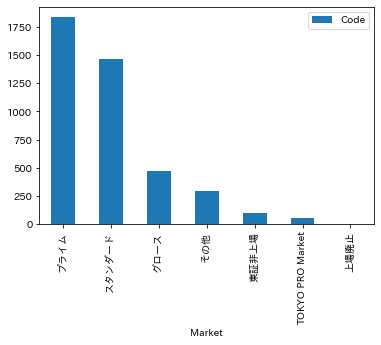

In [19]:
# 市場区分毎の銘柄数を確認
df_list_market = pd.merge(df_list, df_market, on="MarketCode")
df_list_market.groupby("Market")["Code"].count().sort_values(ascending=False).to_frame().plot(kind="bar")

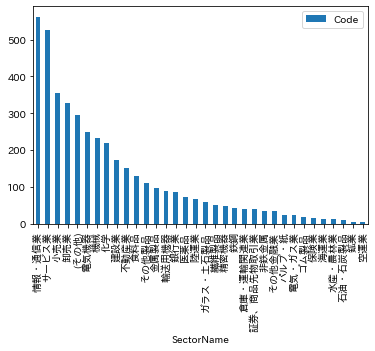

In [20]:
# セクター毎の銘柄数を確認
df_list_sector_market = pd.merge(df_list_market, df_sectors, left_on="SectorCode", right_on="SectorId")
df_list_sector_market.groupby("SectorName")["Code"].count().sort_values(ascending=False).to_frame().plot(kind="bar")

In [21]:
# セクターおよび市場区分ごとの銘柄数確認
# ヒートマップで確認するためにデータを整形します。
df_tmp = df_list_sector_market.groupby(["SectorName", "Market"])["Code"].count().to_frame().reset_index().pivot(
        index="SectorName", columns="Market", values="Code"
    ).fillna(0).astype(int)[["プライム", "スタンダード", "グロース"]]
df_tmp.head(5)

Market,プライム,スタンダード,グロース
SectorName,,,
(その他),0,1,0
その他製品,41,62,6
その他金融業,22,9,3
ガラス・土石製品,24,31,0
ゴム製品,11,8,0


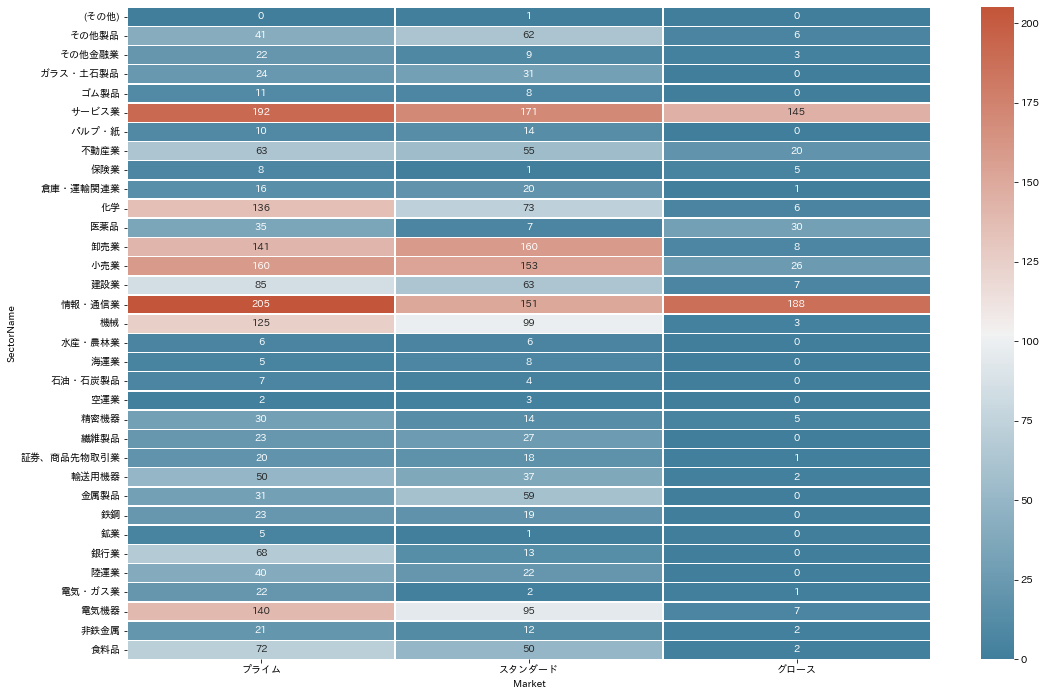

In [22]:
f, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(
    df_tmp,
    annot=True, fmt="d", cmap=sns.diverging_palette(230, 20, as_cmap=True), linewidths=0.5, ax=ax
)

### 株価情報の取得

株価情報は2通りの取得方法が提供されています。それぞれの取得方法を確認してみましょう。

In [23]:
# 日付を指定して取得
df_price = jqapi.get_prices_daily_quotes(date_yyyymmdd="20220517")
df_price.head(2)

,Code,Date,Open,High,Low,Close,Volume,TurnoverValue
0,13010,2022-05-17,3190.0,3295.0,3190.0,3280.0,24500,80016000
1,13050,2022-05-17,2015.0,2015.0,1982.0,1992.0,125740,250444655


In [24]:
# 銘柄コードを指定して取得
df_price = jqapi.get_prices_daily_quotes(code=8697)
df_price.tail(2)

,Code,Date,Open,High,Low,Close,Volume,TurnoverValue
1303,86970,2022-05-17,1884.0,1884.0,1854.0,1863.5,1468100,2742346700
1304,86970,2022-05-18,1866.5,1877.0,1840.5,1851.5,1196800,2218004650


### 財務情報の取得

財務情報も日付を指定して取得する方法と、銘柄コードを指定して取得する方法が提供されています。

In [25]:
# 日付を指定
df_fin = jqapi.get_fins_statements(date_yyyy_mm_dd="2022-05-11")
df_fin.head(2)

,DisclosureNumber,LocalCode,DisclosedDate,DisclosedTime,DisclosedUnixTime,TypeOfDocument,CurrentPeriodEndDate,TypeOfCurrentPeriod,CurrentFiscalYearStartDate,CurrentFiscalYearEndDate,NetSales,OperatingIncome,OrdinaryIncome,NetIncome,NetIncomePerShare,TotalAssets,NetAssets,CapitalAdequacyRatio,NetAssetsPerShare,ResultDividendPerShare1stQuarter,ResultDividendPerShare2ndQuarter,ResultDividendPerShare3rdQuarter,ResultDividendPerShareFiscalYearEnd,ResultDividendPerShareAnnual,ForecastDividendPerShare1stQuarter,ForecastDividendPerShare2ndQuarter,ForecastDividendPerShare3rdQuarter,ForecastDividendPerShareFiscalYearEnd,ForecastDividendPerShareAnnual,ForecastNetSales,ForecastOperatingIncome,ForecastOrdinaryIncome,ForecastNetIncome,ForecastNetIncomePerShare,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,ChangesBasedOnRevisionsOfAccountingStandard,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,RetrospectiveRestatement,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,NumberOfTreasuryStockAtTheEndOfFiscalYear,AverageNumberOfShares
167,20220510537672,75700,2022-05-11,09:45:00,1652262300.0,FYFinancialStatements_Consolidated_JP,2022-03-31,FY,2021-04-01,2022-03-31,137606000000,2504000000,3424000000,2407000000,237.75,64425000000,25941000000,0.402,2553.87,－,35.0,－,35.0,70.0,－,37.0,－,37.0,74.0,145000000000,2800000000,3700000000,2500000000,10646526,,false,true,false,false,false,516313,10127804
54,20220426528245,59580,2022-05-11,11:00:00,1652266800.0,FYFinancialStatements_Consolidated_JP,2022-03-31,FY,2021-04-01,2022-03-31,24533000000,866000000,1084000000,735000000,216.88,26239000000,17143000000,0.653,5054.47,－,35.0,－,35.0,70.0,－,35.0,－,40.0,75.0,26500000000,800000000,1100000000,750000000,3520000,,false,true,false,false,false,128275,3391725


In [26]:
# 銘柄コードを指定
df_fin = jqapi.get_fins_statements(code=8697)
df_fin.tail(2)

,DisclosureNumber,LocalCode,DisclosedDate,DisclosedTime,DisclosedUnixTime,TypeOfDocument,CurrentPeriodEndDate,TypeOfCurrentPeriod,CurrentFiscalYearStartDate,CurrentFiscalYearEndDate,NetSales,OperatingIncome,OrdinaryIncome,NetIncome,NetIncomePerShare,TotalAssets,NetAssets,CapitalAdequacyRatio,NetAssetsPerShare,ResultDividendPerShare1stQuarter,ResultDividendPerShare2ndQuarter,ResultDividendPerShare3rdQuarter,ResultDividendPerShareFiscalYearEnd,ResultDividendPerShareAnnual,ForecastDividendPerShare1stQuarter,ForecastDividendPerShare2ndQuarter,ForecastDividendPerShare3rdQuarter,ForecastDividendPerShareFiscalYearEnd,ForecastDividendPerShareAnnual,ForecastNetSales,ForecastOperatingIncome,ForecastOrdinaryIncome,ForecastNetIncome,ForecastNetIncomePerShare,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,ChangesBasedOnRevisionsOfAccountingStandard,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,RetrospectiveRestatement,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,NumberOfTreasuryStockAtTheEndOfFiscalYear,AverageNumberOfShares
26,20220318508090,86970,2022-03-22,12:00:00,1647918000.0,ForecastRevision,2022-03-31,FY,2021-04-01,2022-03-31,,,,,,,,,,,,,,,,－,－,46.0,72.0,135500000000,73500000000,73500000000,50000000000,,,,,,,,,
27,20220425527054,86970,2022-04-26,12:00:00,1650974400.0,FYFinancialStatements_Consolidated_IFRS,2022-03-31,FY,2021-04-01,2022-03-31,135432000000,73473000000,73429000000,49955000000,94.35,71463434000000,323852000000,0.004,230.88,－,26.0,－,46.0,72.0,－,26.0,－,26.0,52.0,132500000000,65500000000,65500000000,45000000000,528578441,,false,false,false,false,,1037782,529487172


### 財務情報公表予定の取得

In [27]:
df_fin_announcement = jqapi.get_fins_announcement()
df_fin_announcement.head(2)

,Code,Date,CompanyName,FiscalYear,SectorName,FiscalQuarter,Section
1,18410,2022-05-19,サンユー建設,3月31日,建設業,本決算,スタンダード
3,33900,2022-05-19,ＩＮＥＳＴ,3月31日,卸売業,本決算,スタンダード


## J-Quants API からのデータ取得と保存



J-Quants API から毎日データを取得して分析する環境を作るために、日次で必要なデータを取得していきます。

### 銘柄データの取得

以降の作業を容易にするために、市場区分やセクター情報を結合した銘柄リストを作成します。

In [28]:
now = pd.Timestamp.now(tz="Asia/Tokyo")
if now.hour < 22:
  # データ更新時間前の場合は日付を1日ずらします。
  now -= pd.Timedelta(1, unit="D")
list_file = f"{STORAGE_DIR_PATH}/list_{now.strftime('%Y%m%d')}.csv.gz"
if not os.path.isfile(list_file):
  df_list = jqapi.get_list()
  df_list.to_csv(list_file, compression="gzip", index=False)
  print(f"save file: {list_file}")
else:
  print(f"file exists: {list_file}, loading")
  df_list = pd.read_csv(list_file, dtype="str")

file exists: /content/drive/MyDrive/drive_ws/marketdata/list_20220518.csv.gz, loading


In [29]:
df_list.head(2)

,Code,CompanyName,CompanyNameEnglish,CompanyNameFull,SectorCode,UpdateDate,MarketCode,SectorId,SectorName,Market
0,13010,極洋,"KYOKUYO CO.,LTD.",（株）極洋,0050,2022-05-18,A,0050,水産・農林業,プライム
1,13050,ＥＴＦ・ＴＰＸ,Daiwa ETF-TOPIX,大和アセットマネジメント株式会社 ダイワ上場投信−トピックス,9999,2022-05-18,5,9999,(その他),その他


### 株価データの取得

J-Quants API から取得できるデータは調整済み株価であるため、株式の分割などが発生すると値洗いが必要になります。ここではロジックを簡易で済ませるために日次で必要な全データを取得しなおしています。

※株価データの一括取得については、J-Quants API の Early access ユーザーからのご要望を受けて現在JPX様で対応をご検討中とのことです。 (ref. [検討中のもの](https://jpx.gitbook.io/j-quants-api/works#nomono-1))

In [30]:
now = pd.Timestamp.now(tz="Asia/Tokyo")
start_dt = now - pd.offsets.Week(6)
end_dt = now
if end_dt.hour < 19:
  # データ更新時間前の場合は日付を1日ずらします。
  end_dt -= pd.Timedelta(1, unit="D")
price_file = f"{STORAGE_DIR_PATH}/price_{start_dt.strftime('%Y%m%d')}_{end_dt.strftime('%Y%m%d')}.csv.gz"
if not os.path.isfile(price_file):
  df_p = jqapi.get_price_range(start_dt=start_dt, end_dt=end_dt)
  df_p.to_csv(price_file, compression="gzip", index=False)
  print(f"save file: {price_file}")
else:
  print(f"file exists: {price_file}, loading")
  df_p = pd.read_csv(price_file, dtype="str")
  df_p.loc[:, "Date"] = pd.to_datetime(df_p["Date"], format="%Y-%m-%d")

file exists: /content/drive/MyDrive/drive_ws/marketdata/price_20220407_20220518.csv.gz, loading


In [31]:
df_p.tail(2)

,Code,Date,Open,High,Low,Close,Volume,TurnoverValue
108847,99960,2022-05-18,NaN,NaN,NaN,NaN,NaN,NaN
108848,99970,2022-05-18,661.0,667.0,657.0,657.0,199400,131952500


### 財務データの取得

get_statements_all に cache_dir を指定すると、日次のデータをキャシュとして保存しておくため、日次では必要なファイルのみを取得しています。

In [32]:
now = pd.Timestamp.now(tz="Asia/Tokyo")
start_dt = now - pd.Timedelta(14, unit="D")
end_dt = now - pd.Timedelta(1, unit="D")
if end_dt.hour < 1:
  # データ更新時間前の場合は日付を1日ずらします。
  end_dt -= pd.Timedelta(1, unit="D")
statements_file = f"{STORAGE_DIR_PATH}/statements_{start_dt.strftime('%Y%m%d')}_{end_dt.strftime('%Y%m%d')}.csv.gz"
if not os.path.isfile(statements_file):
  cache_dir = f"{STORAGE_DIR_PATH}/raw_statements"
  os.makedirs(cache_dir, exist_ok=True)
  df_s = jqapi.get_statements_range(start_dt=start_dt, end_dt=end_dt, cache_dir=cache_dir)
  df_s.to_csv(statements_file, compression="gzip", index=False)
  print(f"save file: {statements_file}")
else:
  print(f"file exists: {statements_file}, loading")
  df_s = pd.read_csv(statements_file, dtype="str")
  df_s.loc[:, "DisclosedDate"] = pd.to_datetime(df_s["DisclosedDate"], format="%Y-%m-%d")
  df_s.loc[:, "CurrentPeriodEndDate"] = pd.to_datetime(df_s["CurrentPeriodEndDate"], format="%Y-%m-%d")
  df_s.loc[:, "CurrentFiscalYearStartDate"] = pd.to_datetime(df_s["CurrentFiscalYearStartDate"], format="%Y-%m-%d")
  df_s.loc[:, "CurrentFiscalYearEndDate"] = pd.to_datetime(df_s["CurrentFiscalYearEndDate"], format="%Y-%m-%d")
  df_s.sort_values("DisclosedUnixTime", inplace=True)

file exists: /content/drive/MyDrive/drive_ws/marketdata/statements_20220505_20220518.csv.gz, loading


In [33]:
df_s.head(2)

,DisclosureNumber,LocalCode,DisclosedDate,DisclosedTime,DisclosedUnixTime,TypeOfDocument,CurrentPeriodEndDate,TypeOfCurrentPeriod,CurrentFiscalYearStartDate,CurrentFiscalYearEndDate,NetSales,OperatingIncome,OrdinaryIncome,NetIncome,NetIncomePerShare,TotalAssets,NetAssets,CapitalAdequacyRatio,NetAssetsPerShare,ResultDividendPerShare1stQuarter,ResultDividendPerShare2ndQuarter,ResultDividendPerShare3rdQuarter,ResultDividendPerShareFiscalYearEnd,ResultDividendPerShareAnnual,ForecastDividendPerShare1stQuarter,ForecastDividendPerShare2ndQuarter,ForecastDividendPerShare3rdQuarter,ForecastDividendPerShareFiscalYearEnd,ForecastDividendPerShareAnnual,ForecastNetSales,ForecastOperatingIncome,ForecastOrdinaryIncome,ForecastNetIncome,ForecastNetIncomePerShare,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,ChangesBasedOnRevisionsOfAccountingStandard,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,RetrospectiveRestatement,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,NumberOfTreasuryStockAtTheEndOfFiscalYear,AverageNumberOfShares
0,20220421525378,51870,2022-05-06,11:30:00,1651836600.0,1QFinancialStatements_Consolidated_JP,2022-03-31,1Q,2022-01-01,2022-12-31,2928000000.0,165000000.0,222000000.0,132000000.0,14.59,18413000000.0,14359000000.0,0.78,1578.86,－,NaN,NaN,NaN,NaN,NaN,17.0,－,20.0,37.0,11802000000.0,881000000.0,900000000.0,638000000.0,9664327.0,NaN,False,True,False,False,False,569468,9094864.0
1,20220419523888,81730,2022-05-06,12:30:00,1651840200.0,FYFinancialStatements_Consolidated_JP,2022-03-31,FY,2021-04-01,2022-03-31,409508000000.0,8884000000.0,9701000000.0,6391000000.0,238.78,217417000000.0,98641000000.0,0.454,3684.75,－,0.0,－,75.0,75.0,－,0.0,－,75.0,75.0,420000000000.0,10000000000.0,10000000000.0,7000000000.0,28000000.0,NaN,False,True,False,False,False,1229873,26766071.0


## J-Quants APIから取得したデータの分析

ここまでで日次で最新のデータを取得できるようになったため、ここからは取得したデータを使用して分析をしてみたいと思います。一例として注目されているセクターの移り変わりを分析してみたいと思います。

### プライム市場における各セクターの取引代金の変化率

セクターローテーションという言葉が示すように注目されているセクターは市場状況に応じて変化していきます。各セクターごとのリターンを算出して分析することが一般的ですが、ここではプライム市場において各セクターの取引代金が占める割合の変化を分析してみます。

In [34]:
# 株価情報と銘柄情報を結合します
df_work = pd.merge(df_p, df_list, how="inner", on=["Code"])
# 数字型に変換します
df_work.loc[:, "TurnoverValue"] = df_work["TurnoverValue"].astype(np.float64)
df_work.head(2)

,Code,Date,Open,High,Low,Close,Volume,TurnoverValue,CompanyName,CompanyNameEnglish,CompanyNameFull,SectorCode,UpdateDate,MarketCode,SectorId,SectorName,Market
0,13010,2022-04-07,3350.0,3360.0,3315.0,3330.0,23700,78926500.0,極洋,"KYOKUYO CO.,LTD.",（株）極洋,0050,2022-05-18,A,0050,水産・農林業,プライム
1,13010,2022-04-08,3330.0,3330.0,3260.0,3275.0,20900,68779000.0,極洋,"KYOKUYO CO.,LTD.",（株）極洋,0050,2022-05-18,A,0050,水産・農林業,プライム


In [35]:
# プライム市場の過去5週のセクター別の取引額のしめる割合の推移を確認します
last_bday = (pd.Timestamp.now(tz="Asia/Tokyo") - pd.offsets.Week(6)).strftime("%Y-%m-%d")
# データを絞り込みます
df = df_work.loc[(
    (
        # 営業日
        df_work["Date"] >= last_bday
    ) & (
        # プライム市場
        df_work["MarketCode"] == "A"
    )
)].copy()

In [36]:
# 週次でセクターごとの取引代金を集計してフォーマットを整えます
df_turnovervalue = (
    df.groupby(["SectorName", pd.Grouper(key="Date", freq="W")])[["TurnoverValue"]].sum()
).reset_index().pivot('Date','SectorName','TurnoverValue').dropna()
# 週次で各セクターの割合を計算します
df_turnovervalue = df_turnovervalue.div(df_turnovervalue.sum(axis=1), axis=0)
# 割合の前週との変化率を計算します
df_turnovervalue = df_turnovervalue.pct_change().dropna()
# 日付範囲を区切ります
df_turnovervalue = df_turnovervalue.loc[df_turnovervalue.index[1:]]
# 日付の表示方法を変更します
df_turnovervalue.index = df_turnovervalue.index.strftime("%Y-%m-%d")
# 表示用に展開します
df_turnovervalue = df_turnovervalue.T
# 直近の増減でソートします
df_turnovervalue = df_turnovervalue.sort_values(df_turnovervalue.columns[-1], ascending=False)
# 週次での増減を可視化します
df_turnovervalue.style.background_gradient(cmap='RdYlGn',axis=0)

Date,2022-04-24,2022-05-01,2022-05-08,2022-05-15,2022-05-22
SectorName,,,,,
倉庫・運輸関連業,-0.053307,0.260895,0.179802,-0.164986,1.885682
鉱業,0.113704,-0.225583,-0.165799,0.080610,0.531779
銀行業,0.073103,-0.118842,0.124659,-0.152033,0.447903
食料品,0.144508,0.203573,-0.174380,-0.026893,0.346632
パルプ・紙,0.261474,-0.101128,-0.149532,0.278794,0.296262
不動産業,-0.112555,0.151715,-0.143808,-0.049198,0.283177
石油・石炭製品,0.120937,-0.136586,0.132145,0.360176,0.271729
金属製品,0.201697,-0.135522,0.141155,0.136409,0.258261
建設業,-0.084799,0.155843,-0.207741,0.098282,0.243426


本日のデモは以上となります。

J-Quants API を使用することで個人投資家の方々もご自身の観点で市場を分析することができるようになるかと思われます。今回は財務情報についてデータの取得のみで分析はしませんでしたが、J-Quants データ分析コンペティションで上位入賞した機械学習モデルは財務情報からも特徴量を抽出していますように、分析しがいのあるデータとなっております。

J-Quants API が登場することによって、個人投資家が使用可能な Google Colab や Google Cloud などのオンデマンドでの計算資源と組み合わせることで、データドリブンな意思決定をよりしやすい環境が見えてきました。

J-Quants では現在データ分析コンペティション第3弾を実施しています。世界中のデータサイエンティストたちが J-Quants API で取得できるデータと同等のデータを使用して日本株のポートフォリオを組成することに心血を注いでいます。J-Quants API データの有効活用のアイディアを得ることもできるかと思います。締切は2022年7月5日ですので、ご興味を持たれた方は是非ご参加ください。

[JPX Tokyo Stock Exchange Prediction](https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction)